# Лабораторная работа №1
## Выполнили: Новикова Ирина, Шапиро Алина

In [1]:
%pip install -U numpy
%pip install pybind11>=2.12
%pip install datasets==3.2.0
%pip install torch==2.5.1
%pip install transformers==4.45.0
%pip install -U huggingface-hub
%pip install seqeval==1.2.2
%pip install accelerate==0.34.2
%pip install wordcloud
%pip install torchvision

  Using cached numpy-2.3.4-cp311-cp311-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached numpy-2.3.4-cp311-cp311-macosx_14_0_arm64.whl (5.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.3.4 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.
ruts 0.8.1 requires numpy<2.0.0,>=1.23.0, but you have numpy 2.3.4 which is incompatible.
ruts 0.8.1 requires pandas<2.0.0,>=1.4.3, but you have pandas 2.2.3 which is incompatible.
ru-core-news-sm 3.7.0 requires spacy<3.8.0,>=3.7.0, but you have spacy 3.8.2 which is incompatible.
rectools 0.7.0 requires numpy<2.0.0,>=1.22; python_version >= "3.9"

In [2]:
# from google.colab import drive

# drive.mount('/content/drive')

In [3]:
import pandas as pd
import numpy as np
import random
import torch
from datasets import load_dataset
from transformers import AutoModelForTokenClassification, AutoTokenizer, TrainingArguments, Trainer, pipeline
from transformers import DataCollatorForTokenClassification
from seqeval.metrics import classification_report
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from collections import Counter,  defaultdict
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib as mpl

from IPython.display import display, HTML
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/irinanovikova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/irinanovikova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
def set_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Exploratory Data Analysis

In [5]:
dataset = load_dataset("eriktks/conll2003", trust_remote_code=True)

В данной работе использовался датасет `CoNLL-2003`.

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [7]:
df_train = pd.DataFrame(dataset['train'])
df_train.head()

,id,tokens,pos_tags,chunk_tags,ner_tags
0,0,"[EU, rejects, German, call, to, boycott, Briti...","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[11, 21, 11, 12, 21, 22, 11, 12, 0]","[3, 0, 7, 0, 0, 0, 7, 0, 0]"
1,1,"[Peter, Blackburn]","[22, 22]","[11, 12]","[1, 2]"
2,2,"[BRUSSELS, 1996-08-22]","[22, 11]","[11, 12]","[5, 0]"
3,3,"[The, European, Commission, said, on, Thursday...","[12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...","[11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ..."
4,4,"[Germany, 's, representative, to, the, Europea...","[22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...","[11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ..."


In [8]:
# Dataset size
for split in dataset:
    print(f"{split.title()} split: {len(dataset[split])} samples")

Train split: 14041 samples
Validation split: 3250 samples
Test split: 3453 samples


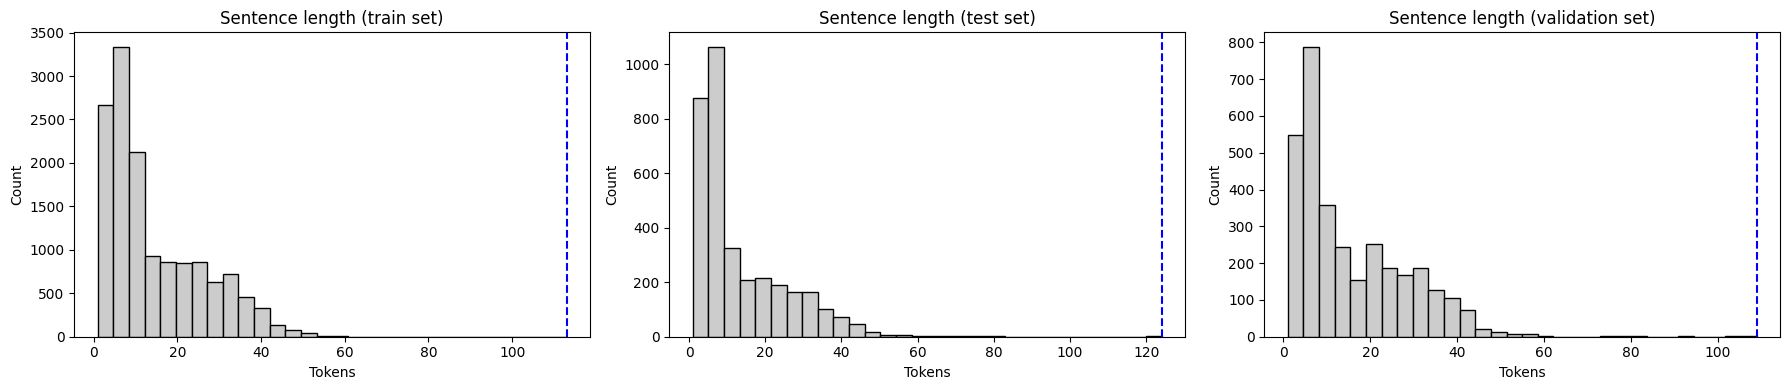

In [9]:

splits = ["train", "test", "validation"]
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
for i, split in enumerate(splits):
    lengths = [len(x['tokens']) for x in dataset[split]]
    axs[i].hist(lengths, bins=30, color='0.8', edgecolor='black')
    axs[i].axvline(x=max(lengths), color='b', linestyle='--')
    axs[i].set_title(f'Sentence length ({split} set)')
    axs[i].set_xlabel('Tokens')
    axs[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

Исходя из передставленных распределений количества токенов в текстах, можно сделать вывод, что наши текущие тексты очень короткие (менее 113 токенов), поэтому в дальнейшем не нужно разбивать их на маленькие чанки. Для длинных документов мы бы это сделали, чтобы не упустить важную информацию и чтобы все куски были примерно одной длины.

Кроме того, можно отметить, что распределения длин текстов в train, test и validation выборках также одинаково.

In [10]:
dataset["train"].features['ner_tags'].feature.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

В датасете присутствуют следующие именнованные сущности:

* PER - Person (Имена людей)
* ORG - Organization (Организации) - названия компаний, агентств, учреждений
* LOC - Location (Местоположение) - названия географических мест, таких как города, страны, регионы, горы.
* MISC - Miscellaneous (Разное) - именованные сущности, которые не подходят ни к одному из трех других типов

Схема BIO используется для маркировки начала и продолжения именованных сущностей, состоящих из нескольких слов.

* B - cлово является началом именованной сущности
* I - слово находится внутри именованной сущности
* O - cлово не является частью именованной сущности

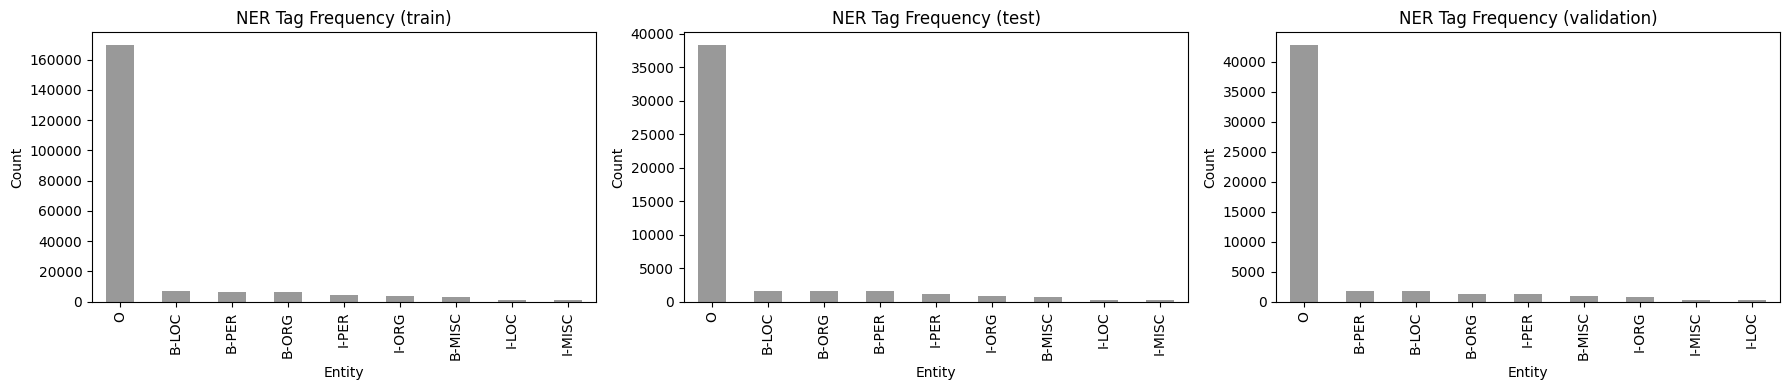

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
for i, split in enumerate(splits):
    entity_tags = np.concatenate(dataset[split]['ner_tags'])
    label_names = dataset[split].features['ner_tags'].feature.names
    tag_counts = Counter(entity_tags)
    tag_counts_named = {label_names[j]: tag_counts[j] for j in tag_counts}
    pd.Series(tag_counts_named).sort_values(ascending=False).plot(
        kind='bar', color='0.6', ax=axs[i]
    )
    axs[i].set_title(f'NER Tag Frequency ({split})')
    axs[i].set_xlabel('Entity')
    axs[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [12]:
for split in splits:
  print(f"\n=== {split.upper()} SPLIT ===")
  entities = defaultdict(set)
  label_names = dataset[split].features["ner_tags"].feature.names
  for tokens, tags in zip(dataset[split]["tokens"], dataset[split]["ner_tags"]):
      current_entity, current_label = [], None
      for token, tag in zip(tokens, tags):
          label = label_names[tag]

          if label.startswith('B-'):
              if current_entity:
                  entities[current_label].add(' '.join(current_entity))
              current_entity = [token]
              current_label = label[2:]
          elif label.startswith('I-') and current_entity:
              current_entity.append(token)
          else:
              if current_entity:
                  entities[current_label].add(' '.join(current_entity))
                  current_entity, current_label = [], None
      if current_entity:
          entities[current_label].add(' '.join(current_entity))
  for ent_type, ent_list in entities.items():
      print(f"{ent_type}: {len(ent_list)} Unique entities.")


=== TRAIN SPLIT ===
ORG: 2403 Unique entities.
MISC: 871 Unique entities.
PER: 3614 Unique entities.
LOC: 1332 Unique entities.

=== TEST SPLIT ===
LOC: 505 Unique entities.
PER: 1100 Unique entities.
MISC: 301 Unique entities.
ORG: 795 Unique entities.

=== VALIDATION SPLIT ===
ORG: 675 Unique entities.
LOC: 535 Unique entities.
MISC: 350 Unique entities.
PER: 1294 Unique entities.


* Метка "O"  встречается на порядок чаще, чем любые другие метки, что логично, так как именованные сущности встречаются в предложениях реже остальных слов
* Можно отметить, что в распределении NER тегов наблюдается дисбаланс, так как наиболее распространенным является тег PERю Он встреяается в 2-3 раза чаще, чем остальные теги. На втором месте по частотности находится тего ORG, далее LOC и MISC. Вероятно, такое неравномерное распределение тегов может привести к тому, что тег MISC будет предсказываться хуже в результате работы модели. 
* Распределение тего именованных сущностей по выборкам репрезентативно. Однако можно отметить, что в тестовой выборке класс MISC представлен в наименьшей степени. 


In [13]:
for split in splits:
  print(f"\n\n--- Entity Lengths in {split} split---")
  entity_lengths_count = defaultdict(list)
  label_names = dataset[split].features["ner_tags"].feature.names
  for tokens, tags in zip(dataset[split]['tokens'], dataset[split]['ner_tags']):
      current_entity = []
      current_label = None

      for token, tag_id in zip(tokens, tags):
          label = label_names[tag_id]
          if label.startswith("B-"):
              if current_entity:
                  entity_lengths_count[current_label].append(len(current_entity))
              current_entity = [token]
              current_label = label[2:]
          elif label.startswith("I-") and current_label == label[2:]:
              current_entity.append(token)
          else:
              if current_entity:
                  entity_lengths_count[current_label].append(len(current_entity))
              current_entity = []
              current_label = None
      if current_entity:
          entity_lengths_count[current_label].append(len(current_entity))
  avg_lengths = {label: np.mean(lengths) for label, lengths in entity_lengths_count.items()}

  for label, mean_len in avg_lengths.items():
      print(f"[{label}]:  average length = {mean_len:.2f} tokens")



--- Entity Lengths in train split---
[ORG]:  average length = 1.59 tokens
[MISC]:  average length = 1.34 tokens
[PER]:  average length = 1.69 tokens
[LOC]:  average length = 1.16 tokens


--- Entity Lengths in test split---
[LOC]:  average length = 1.15 tokens
[PER]:  average length = 1.71 tokens
[MISC]:  average length = 1.31 tokens
[ORG]:  average length = 1.50 tokens


--- Entity Lengths in validation split---
[ORG]:  average length = 1.56 tokens
[LOC]:  average length = 1.14 tokens
[MISC]:  average length = 1.38 tokens
[PER]:  average length = 1.71 tokens


Вероятно модель будет иметь высокую точность при распознавании LOC , так как в основном локации состоят из одногослова, и будет чаще совершать ошибки в определении границ для сущностей PER (почти всегда это может быть имя и фамилия) и ORG (названия организаций).

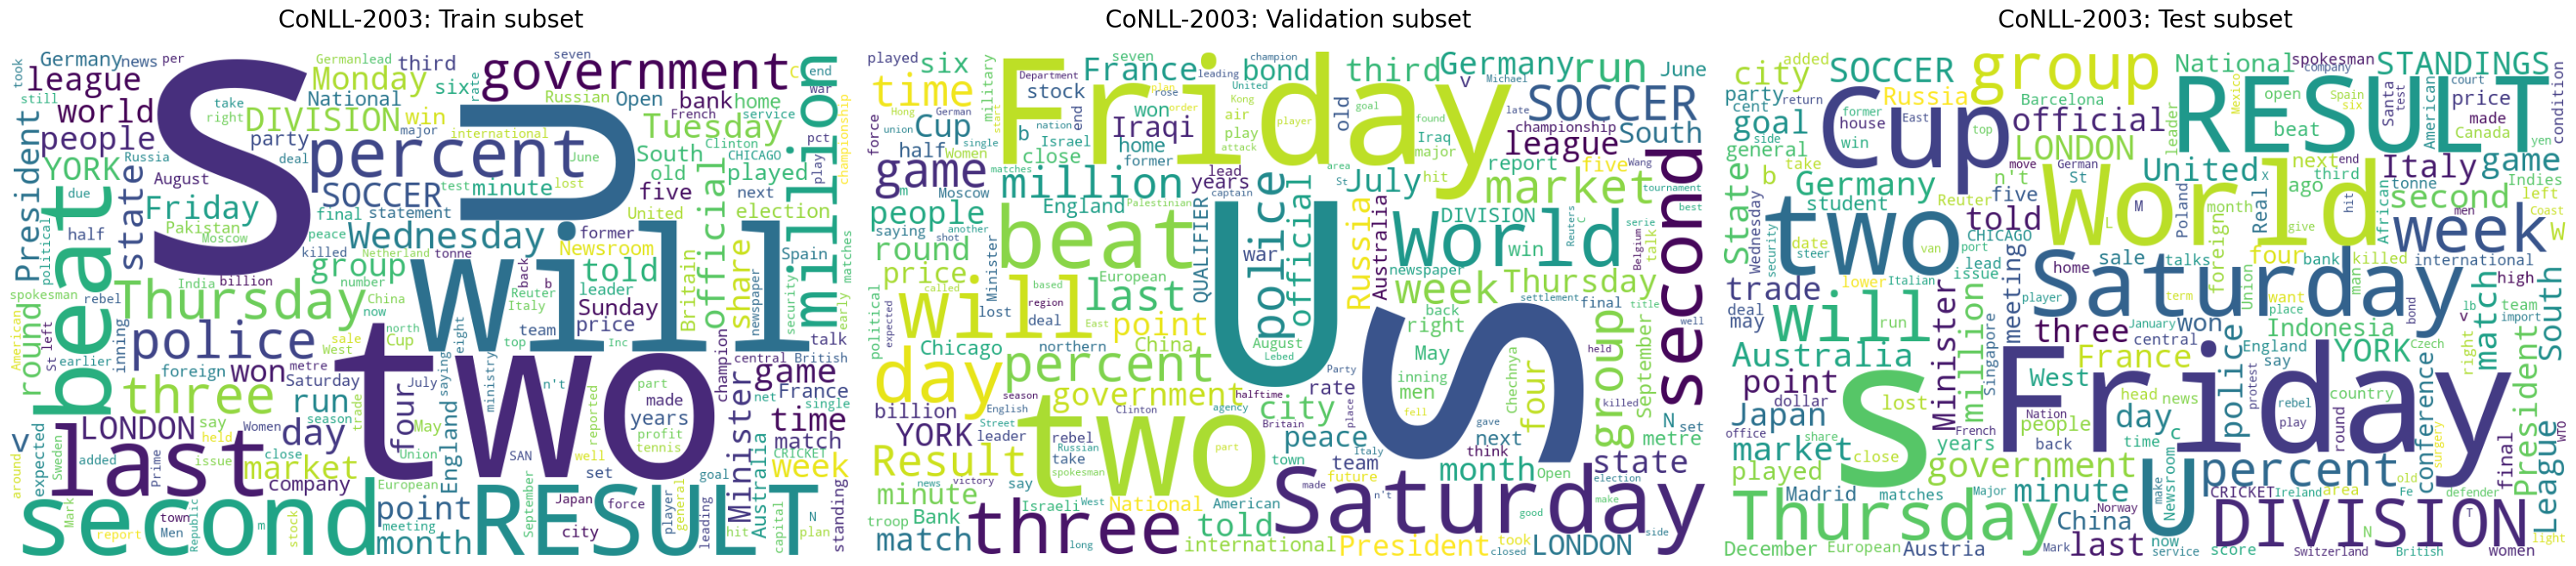

In [14]:
custom_stopwords = set(STOPWORDS) | {"said", "mr", "mrs", "would", "one", "first", "year", "new"}

fig, axes = plt.subplots(1, len(dataset), figsize=(30, 8))

def generate_wordcloud_from_subset(subset, title, ax):

    text = " ".join(" ".join(tokens) for tokens in subset["tokens"])
    wc = WordCloud(width=1000, height=600, background_color="white",
                   stopwords=custom_stopwords, collocations=False).generate(text)

    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(title, fontsize=20, pad=20)

for i, split in enumerate(dataset):
    generate_wordcloud_from_subset(dataset[split], f"CoNLL-2003: {split.capitalize()} subset", axes[i])

plt.tight_layout()
plt.show()

Мы убедились, что  между сабсетами присутствует семантическая согласованность, что  позволяет исключить проблемы, связанные с out-of-distribution данными.

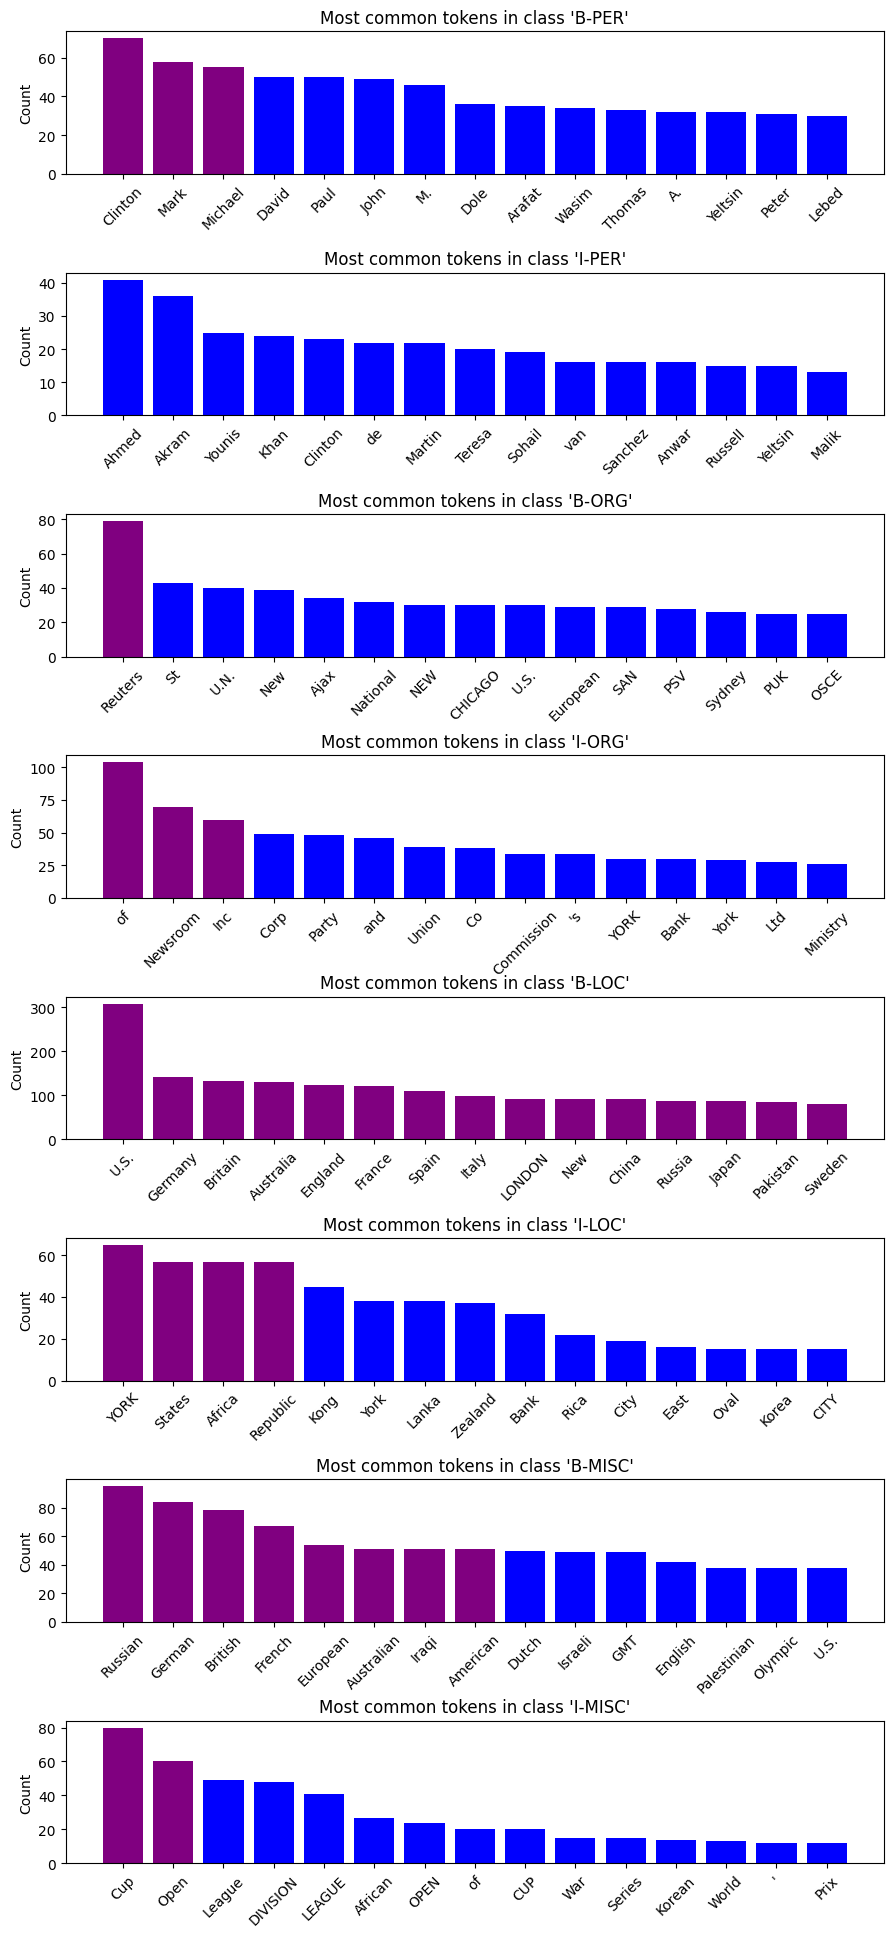

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset

label_list = dataset["train"].features["ner_tags"].feature.names
def most_popular_tokens_by_tag(split, tag_name):
    tag_idx = label_list.index(tag_name)
    counter = Counter()

    for tokens, tags in zip(split["tokens"], split["ner_tags"]):
        for token, t in zip(tokens, tags):
            if t == tag_idx:
                counter[token] += 1

    count_tags_df = pd.DataFrame(counter.most_common(15), columns=["word", "count"])
    return count_tags_df

def color_change(counts):
    return ['purple' if c > 50 else 'blue' for c in counts]

def plot_popular_tokens(dataset_split):
    fig, axs = plt.subplots(len(label_list[1:]), 1, figsize=(10, 20))
    fig.tight_layout(pad=5.0)

    for i, tag_name in enumerate(label_list[1:]):  # пропускаем 'O'
        df_tags = most_popular_tokens_by_tag(dataset_split, tag_name)
        axs[i].bar(df_tags["word"], df_tags["count"], color=color_change(df_tags["count"]))
        axs[i].set_title(f"Most common tokens in class '{tag_name}'")
        axs[i].set_ylabel("Count")
        axs[i].tick_params(axis='x', rotation=45)

    plt.show()

plot_popular_tokens(dataset["train"])


Исходя из распределений наиболее частотных токенов в разных классах именованных сущностей, можно отметить, что тексты, представленные в датасете, в основном описывают спортивные события и политику.
* PER - Преобладают имена (B-PER) или фамилии (I-PER). Частота относительно невысока, что указывает на большое разнообразие упоминаемых людей.
* ORG - Присутствуют названия СМИ, а также международныхт и национальных организаций. Интересно, что наиболее частотным словом является предлог `of`. 
* LOC - Подавляющее большинство сущностей представляют собой названиями стран или крупных городов. Количество этих токенов значительно выше, чем у других типов сущностей, что говорит о высокой плотности в корпусе.
* MISC - состоит из назаний национальных групп (B-MISC), событий, продуктов и т.д.

# Pre-processing

In [16]:
def clean_text(tokens):
    """
    Очистка токенов от шумов и нормализация.
    CoNLL2003 — не OCR-текст, но базовая чистка улучшает консистентность.
    """
    cleaned = []
    for token in tokens:
        # удаляем лишние пробелы, невидимые символы
        token = token.strip()
        # удаляем пунктуацию кроме дефисов и точек (часто часть имён)
        token = re.sub(r"[^\w\-\.\']+", "", token)
        if token != "":
            cleaned.append(token)
    return cleaned

# Inference of fine-tuned model

Попробуем поинфереть уже предобученную на таком же датасете LLM модель и посмотреть, какое она даст качество, чтобы использовать эти значения в качестве бейзлайна. 

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
model_name = "dslim/distilbert-NER"

In [19]:
ner_feature = dataset["train"].features["ner_tags"]
label_names = ner_feature.feature.names

In [20]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [21]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForTokenClassification.from_pretrained(model_name, id2label=id2label, label2id=label2id).to(device)

In [22]:
# Токенизация и выравнивание меток
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            new_labels.append(-100)
        else:
            label = labels[word_id]
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [23]:
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset["train"].column_names,
)

In [24]:
idx = 8
decoded = [tokenizer.decode(t) for t in tokenized_datasets["validation"][idx]["input_ids"] ][1:-1] # except [CLS] and [SEP]
print(decoded)
tags = [id2label[t] for t in tokenized_datasets["validation"][idx]["labels"] if t !=-100]
print(tags)

['By', 'the', 'close', 'Yorkshire', 'had', 'turned', 'that', 'into', 'a', '37', '-', 'run', 'advantage', 'but', 'off', '-', 'spin', '##ner', 'Such', 'had', 's', '##cut', '##tled', 'their', 'hopes', ',', 'taking', 'four', 'for', '24', 'in', '48', 'balls', 'and', 'leaving', 'them', 'hanging', 'on', '119', 'for', 'five', 'and', 'praying', 'for', 'rain', '.']
['O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [25]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = {
        'classification_report': classification_report(true_labels, true_predictions),
    }
    return results

In [26]:
args = TrainingArguments(
    "data/checkpoint",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=1,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01
)

In [27]:
train_subset_ratio = 0.05
tokenized_datasets["train"] = Subset(
    tokenized_datasets["train"],
    list(range(int(train_subset_ratio*len(tokenized_datasets["train"]))))
)

eval_subset_ratio = 0.5
tokenized_datasets["validation"] = Subset(
    tokenized_datasets["validation"],
    list(range(int(eval_subset_ratio*len(tokenized_datasets["validation"]))))
)

In [28]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [29]:
eval_results_before_train = trainer.evaluate()
eval_results_before_train = pd.DataFrame([eval_results_before_train])

  0%|          | 0/204 [00:00<?, ?it/s]

Trainer is attempting to log a value of "              precision    recall  f1-score   support

         LOC       0.32      0.63      0.43       890
        MISC       0.40      0.65      0.50       397
         ORG       0.20      0.43      0.27       558
         PER       0.24      0.46      0.32       830

   micro avg       0.28      0.54      0.37      2675
   macro avg       0.29      0.54      0.38      2675
weighted avg       0.28      0.54      0.37      2675
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [30]:
def merge_subtokens(preds):
    merged = []
    current = None
    for p in preds:
        word, label, start, end = p['word'], p['entity_group'], p['start'], p['end']
        if current is None:
            current = {'entity_group': label, 'start': start, 'end': end, 'word': word}
            continue

        if label == current['entity_group']:
            if word.startswith("##"):
                current['word'] += word[2:]
            else:
                current['word'] += " " + word
            current['end'] = end
        else:
            merged.append(current)
            current = {'entity_group': label, 'start': start, 'end': end, 'word': word}
    if current:
        merged.append(current)
    return merged

def show_ner_comparison(text, gt_tags, preds):
    print(f"Raw Pred: {preds}")
    gt_html = ""

    colors = {
        "PER": "lightgreen",
        "LOC": "lightblue",
        "ORG": "lightcoral",
        "MISC": "khaki"
    }
    for word, tag_id in zip(text.split(), gt_tags):
        tag = id2label[tag_id]
        if tag != "O":
            tag_type = tag.split("-")[-1]  # убираем B-/I-
            color = colors.get(tag_type, "lightgray")
            gt_html += f"<mark style='background-color:{color}'>{word} [{tag_type}]</mark> "
        else:
            gt_html += f"{word} "
    merged_preds = merge_subtokens(preds)
    pred_html = ""
    last_idx = 0
    for p in merged_preds:
        start, end, label, word = p["start"], p["end"], p["entity_group"], p["word"]
        color = colors.get(label, "lightgray")
        # добавляем текст между предыдущей сущностью и этой
        pred_html += text[last_idx:start]
        # добавляем подсвеченную сущность
        pred_html += f"<mark style='background-color:{color}'>{word} [{label}]</mark>"
        last_idx = end
    pred_html += text[last_idx:]

    display(HTML(f"<b>GT:</b> {gt_html}<br><b>Pred:</b> {pred_html}"))

In [31]:
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=device)

indices = random.sample(range(len(dataset["validation"])), 20)
for idx in indices:
    example = dataset["validation"][idx]
    sentence_text = " ".join(example["tokens"])
    predictions = ner_pipeline(sentence_text)
    show_ner_comparison(sentence_text, dataset["validation"][idx]["ner_tags"], predictions)

Raw Pred: [{'entity_group': 'MISC', 'score': np.float32(0.9982699), 'word': 'Turkish', 'start': 39, 'end': 46}]


Raw Pred: [{'entity_group': 'PER', 'score': np.float32(0.99883777), 'word': 'Me', 'start': 3, 'end': 5}, {'entity_group': 'PER', 'score': np.float32(0.99911344), 'word': '##rlene Ottey', 'start': 5, 'end': 16}, {'entity_group': 'LOC', 'score': np.float32(0.99906045), 'word': 'Jamaica', 'start': 19, 'end': 26}]


Raw Pred: [{'entity_group': 'LOC', 'score': np.float32(0.9981741), 'word': 'M', 'start': 0, 'end': 1}, {'entity_group': 'LOC', 'score': np.float32(0.9981173), 'word': '##OS', 'start': 1, 'end': 3}, {'entity_group': 'LOC', 'score': np.float32(0.9982912), 'word': '##CO', 'start': 3, 'end': 5}, {'entity_group': 'LOC', 'score': np.float32(0.9979425), 'word': '##W', 'start': 5, 'end': 6}]


Raw Pred: []


Raw Pred: []


Raw Pred: []


Raw Pred: [{'entity_group': 'LOC', 'score': np.float32(0.998706), 'word': 'Poland', 'start': 0, 'end': 6}, {'entity_group': 'PER', 'score': np.float32(0.99865085), 'word': 'Darius', 'start': 27, 'end': 33}, {'entity_group': 'PER', 'score': np.float32(0.99893636), 'word': '##z Rosati', 'start': 33, 'end': 41}, {'entity_group': 'LOC', 'score': np.float32(0.99916244), 'word': 'Yugoslavia', 'start': 53, 'end': 63}, {'entity_group': 'ORG', 'score': np.float32(0.99859923), 'word': 'PA', 'start': 173, 'end': 175}, {'entity_group': 'ORG', 'score': np.float32(0.998901), 'word': '##P', 'start': 175, 'end': 176}]


Raw Pred: [{'entity_group': 'MISC', 'score': np.float32(0.91090226), 'word': 'Atlanta Games', 'start': 0, 'end': 13}, {'entity_group': 'PER', 'score': np.float32(0.9979785), 'word': 'Edwards', 'start': 34, 'end': 41}, {'entity_group': 'LOC', 'score': np.float32(0.9979665), 'word': 'Sarajevo', 'start': 99, 'end': 107}, {'entity_group': 'LOC', 'score': np.float32(0.99746644), 'word': 'Bosnia', 'start': 146, 'end': 152}, {'entity_group': 'LOC', 'score': np.float32(0.9133429), 'word': 'Balkans', 'start': 188, 'end': 195}, {'entity_group': 'LOC', 'score': np.float32(0.99880815), 'word': 'Milan', 'start': 238, 'end': 243}]


Raw Pred: [{'entity_group': 'PER', 'score': np.float32(0.9911265), 'word': 'Wang', 'start': 24, 'end': 28}, {'entity_group': 'LOC', 'score': np.float32(0.99867463), 'word': 'China', 'start': 83, 'end': 88}]


Raw Pred: [{'entity_group': 'PER', 'score': np.float32(0.9992786), 'word': 'Frank Busemann', 'start': 3, 'end': 17}, {'entity_group': 'LOC', 'score': np.float32(0.99903154), 'word': 'Germany', 'start': 20, 'end': 27}]


Raw Pred: [{'entity_group': 'LOC', 'score': np.float32(0.9967699), 'word': 'U', 'start': 25, 'end': 26}, {'entity_group': 'LOC', 'score': np.float32(0.9969296), 'word': '.', 'start': 26, 'end': 27}, {'entity_group': 'LOC', 'score': np.float32(0.99659973), 'word': 'S', 'start': 27, 'end': 28}, {'entity_group': 'LOC', 'score': np.float32(0.993541), 'word': '.', 'start': 28, 'end': 29}, {'entity_group': 'MISC', 'score': np.float32(0.99785054), 'word': 'French', 'start': 32, 'end': 38}, {'entity_group': 'MISC', 'score': np.float32(0.9973447), 'word': 'British', 'start': 43, 'end': 50}]


Raw Pred: []


Raw Pred: [{'entity_group': 'ORG', 'score': np.float32(0.9963307), 'word': 'Bud', 'start': 0, 'end': 3}, {'entity_group': 'ORG', 'score': np.float32(0.99590933), 'word': '##uc', 'start': 3, 'end': 5}, {'entity_group': 'ORG', 'score': np.float32(0.9821338), 'word': '##nos', 'start': 5, 'end': 8}, {'entity_group': 'ORG', 'score': np.float32(0.99295616), 'word': '##t ( V )', 'start': 8, 'end': 15}, {'entity_group': 'ORG', 'score': np.float32(0.9992379), 'word': 'OF', 'start': 18, 'end': 20}, {'entity_group': 'ORG', 'score': np.float32(0.99912566), 'word': '##K Beograd', 'start': 20, 'end': 29}]


Raw Pred: []


Raw Pred: [{'entity_group': 'ORG', 'score': np.float32(0.99925643), 'word': 'B', 'start': 0, 'end': 1}, {'entity_group': 'ORG', 'score': np.float32(0.9992938), 'word': '##OS', 'start': 1, 'end': 3}, {'entity_group': 'ORG', 'score': np.float32(0.99925965), 'word': '##TO', 'start': 3, 'end': 5}, {'entity_group': 'ORG', 'score': np.float32(0.99922395), 'word': '##N', 'start': 5, 'end': 6}]


Raw Pred: [{'entity_group': 'LOC', 'score': np.float32(0.9972474), 'word': 'B', 'start': 0, 'end': 1}, {'entity_group': 'LOC', 'score': np.float32(0.9978537), 'word': '##IR', 'start': 1, 'end': 3}, {'entity_group': 'LOC', 'score': np.float32(0.99785703), 'word': '##MI', 'start': 3, 'end': 5}, {'entity_group': 'LOC', 'score': np.float32(0.997789), 'word': '##NG', 'start': 5, 'end': 7}, {'entity_group': 'LOC', 'score': np.float32(0.9982273), 'word': '##HA', 'start': 7, 'end': 9}, {'entity_group': 'LOC', 'score': np.float32(0.9981305), 'word': '##M', 'start': 9, 'end': 10}, {'entity_group': 'LOC', 'score': np.float32(0.99861443), 'word': 'England', 'start': 13, 'end': 20}]


Raw Pred: [{'entity_group': 'MISC', 'score': np.float32(0.99008286), 'word': 'South Korean', 'start': 11, 'end': 23}]


Raw Pred: [{'entity_group': 'MISC', 'score': np.float32(0.9346778), 'word': 'H', 'start': 9, 'end': 10}, {'entity_group': 'MISC', 'score': np.float32(0.9031268), 'word': '##ON', 'start': 10, 'end': 12}, {'entity_group': 'MISC', 'score': np.float32(0.9556384), 'word': '##G KONG OPEN', 'start': 12, 'end': 23}]


Raw Pred: [{'entity_group': 'LOC', 'score': np.float32(0.9988018), 'word': 'Jamaica', 'start': 0, 'end': 7}, {'entity_group': 'PER', 'score': np.float32(0.9991364), 'word': 'Michael Green', 'start': 11, 'end': 24}, {'entity_group': 'PER', 'score': np.float32(0.99852693), 'word': 'Bailey', 'start': 52, 'end': 58}]


Raw Pred: [{'entity_group': 'LOC', 'score': np.float32(0.98595226), 'word': 'Tavi', 'start': 24, 'end': 28}, {'entity_group': 'LOC', 'score': np.float32(0.99117434), 'word': '##lda', 'start': 28, 'end': 31}, {'entity_group': 'LOC', 'score': np.float32(0.9848712), 'word': '##ra', 'start': 31, 'end': 33}]


В результате инференса можно сделать следующие выводы:
* Несмотря на то, что в HuggingFace репозитории представлены достаточно высокие результаты работы модели, полученный нами `weighted_avg` составил 0.54;
* В некоторых примерах можно отметить, что модель некорректно объединяет именованные сущности. Например: `BIRMINGHAM [ORG]`, `England [LOC]` VS `BIRMINGHAM England [LOC]` или совершает ошибки при разметке.

# Fine-tuning

Теперь зафайнтюним предобученный `distilbert` на нашем датасете.

In [32]:
model_name = 'distilbert-base-cased'

In [33]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
model_name,

id2label=id2label,
label2id=label2id
).to(device)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [35]:
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset["train"].column_names,
)

In [36]:
train_subset_ratio = 0.3
tokenized_datasets["train"] = Subset(
    tokenized_datasets["train"],
    list(range(int(train_subset_ratio*len(tokenized_datasets["train"]))))
)

eval_subset_ratio = 0.5
tokenized_datasets["validation"] = Subset(
    tokenized_datasets["validation"],
    list(range(int(eval_subset_ratio*len(tokenized_datasets["validation"]))))
)

In [37]:
args = TrainingArguments(
    "data/checkpoint",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=1,
    learning_rate=2e-5,
    num_train_epochs=4,
    weight_decay=0.01
)

In [38]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [39]:
eval_results_before_train = trainer.evaluate()
eval_results_before_train = pd.DataFrame([eval_results_before_train])

  0%|          | 0/204 [00:00<?, ?it/s]

Trainer is attempting to log a value of "              precision    recall  f1-score   support

         LOC       0.02      0.17      0.03       890
        MISC       0.00      0.04      0.01       397
         ORG       0.00      0.04      0.01       558
         PER       0.00      0.01      0.00       830

   micro avg       0.01      0.07      0.01      2675
   macro avg       0.01      0.06      0.01      2675
weighted avg       0.01      0.07      0.01      2675
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Ввиду того, что предтренированная модель не работала с NER данными, результаты инференса перед дообучением крайне низкие. 

In [40]:
model = model.to(device)

In [41]:
trainer.train()

  0%|          | 0/2108 [00:00<?, ?it/s]

{'loss': 2.1196, 'grad_norm': 7.161132335662842, 'learning_rate': 1.9990512333965847e-05, 'epoch': 0.0}
{'loss': 1.9624, 'grad_norm': 6.932863712310791, 'learning_rate': 1.998102466793169e-05, 'epoch': 0.0}
{'loss': 1.8921, 'grad_norm': 7.9897284507751465, 'learning_rate': 1.9971537001897535e-05, 'epoch': 0.01}
{'loss': 1.7583, 'grad_norm': 8.038313865661621, 'learning_rate': 1.9962049335863377e-05, 'epoch': 0.01}
{'loss': 1.6169, 'grad_norm': 7.4420166015625, 'learning_rate': 1.9952561669829226e-05, 'epoch': 0.01}
{'loss': 1.5646, 'grad_norm': 7.206695079803467, 'learning_rate': 1.9943074003795068e-05, 'epoch': 0.01}
{'loss': 1.5599, 'grad_norm': 5.95762825012207, 'learning_rate': 1.9933586337760913e-05, 'epoch': 0.01}
{'loss': 1.4717, 'grad_norm': 5.9646525382995605, 'learning_rate': 1.9924098671726755e-05, 'epoch': 0.02}
{'loss': 1.2602, 'grad_norm': 7.503722667694092, 'learning_rate': 1.99146110056926e-05, 'epoch': 0.02}
{'loss': 1.4738, 'grad_norm': 4.202714443206787, 'learning_ra

  0%|          | 0/204 [00:00<?, ?it/s]

Trainer is attempting to log a value of "              precision    recall  f1-score   support

         LOC       0.85      0.91      0.88       890
        MISC       0.60      0.69      0.64       397
         ORG       0.70      0.70      0.70       558
         PER       0.92      0.95      0.93       830

   micro avg       0.80      0.84      0.82      2675
   macro avg       0.77      0.81      0.79      2675
weighted avg       0.80      0.84      0.82      2675
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.11523257195949554, 'eval_model_preparation_time': 0.0008, 'eval_classification_report': '              precision    recall  f1-score   support\n\n         LOC       0.85      0.91      0.88       890\n        MISC       0.60      0.69      0.64       397\n         ORG       0.70      0.70      0.70       558\n         PER       0.92      0.95      0.93       830\n\n   micro avg       0.80      0.84      0.82      2675\n   macro avg       0.77      0.81      0.79      2675\nweighted avg       0.80      0.84      0.82      2675\n', 'eval_runtime': 4.6359, 'eval_samples_per_second': 350.523, 'eval_steps_per_second': 44.004, 'epoch': 1.0}
{'loss': 0.0276, 'grad_norm': 1.3053051233291626, 'learning_rate': 1.4990512333965846e-05, 'epoch': 1.0}
{'loss': 0.104, 'grad_norm': 2.119032382965088, 'learning_rate': 1.498102466793169e-05, 'epoch': 1.0}
{'loss': 0.0114, 'grad_norm': 0.7466937303543091, 'learning_rate': 1.4971537001897533e-05, 'epoch': 1.01}
{'loss': 0.1651, 'grad_norm'

  0%|          | 0/204 [00:00<?, ?it/s]

Trainer is attempting to log a value of "              precision    recall  f1-score   support

         LOC       0.87      0.93      0.90       890
        MISC       0.64      0.79      0.71       397
         ORG       0.76      0.75      0.75       558
         PER       0.93      0.95      0.94       830

   micro avg       0.83      0.88      0.85      2675
   macro avg       0.80      0.86      0.83      2675
weighted avg       0.83      0.88      0.85      2675
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.11960694938898087, 'eval_model_preparation_time': 0.0008, 'eval_classification_report': '              precision    recall  f1-score   support\n\n         LOC       0.87      0.93      0.90       890\n        MISC       0.64      0.79      0.71       397\n         ORG       0.76      0.75      0.75       558\n         PER       0.93      0.95      0.94       830\n\n   micro avg       0.83      0.88      0.85      2675\n   macro avg       0.80      0.86      0.83      2675\nweighted avg       0.83      0.88      0.85      2675\n', 'eval_runtime': 4.7114, 'eval_samples_per_second': 344.907, 'eval_steps_per_second': 43.299, 'epoch': 2.0}
{'loss': 0.016, 'grad_norm': 0.5897952914237976, 'learning_rate': 9.990512333965845e-06, 'epoch': 2.0}
{'loss': 0.013, 'grad_norm': 0.9527875781059265, 'learning_rate': 9.981024667931688e-06, 'epoch': 2.0}
{'loss': 0.0148, 'grad_norm': 1.1842113733291626, 'learning_rate': 9.971537001897534e-06, 'epoch': 2.01}
{'loss': 0.1392, 'grad_norm': 

  0%|          | 0/204 [00:00<?, ?it/s]

Trainer is attempting to log a value of "              precision    recall  f1-score   support

         LOC       0.88      0.94      0.91       890
        MISC       0.72      0.83      0.77       397
         ORG       0.77      0.78      0.78       558
         PER       0.94      0.95      0.94       830

   micro avg       0.85      0.89      0.87      2675
   macro avg       0.83      0.87      0.85      2675
weighted avg       0.85      0.89      0.87      2675
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.10730691999197006, 'eval_model_preparation_time': 0.0008, 'eval_classification_report': '              precision    recall  f1-score   support\n\n         LOC       0.88      0.94      0.91       890\n        MISC       0.72      0.83      0.77       397\n         ORG       0.77      0.78      0.78       558\n         PER       0.94      0.95      0.94       830\n\n   micro avg       0.85      0.89      0.87      2675\n   macro avg       0.83      0.87      0.85      2675\nweighted avg       0.85      0.89      0.87      2675\n', 'eval_runtime': 4.8212, 'eval_samples_per_second': 337.056, 'eval_steps_per_second': 42.313, 'epoch': 3.0}
{'loss': 0.138, 'grad_norm': 4.427600860595703, 'learning_rate': 4.990512333965844e-06, 'epoch': 3.0}
{'loss': 0.0733, 'grad_norm': 2.937790632247925, 'learning_rate': 4.981024667931689e-06, 'epoch': 3.0}
{'loss': 0.0012, 'grad_norm': 0.028299380093812943, 'learning_rate': 4.9715370018975335e-06, 'epoch': 3.01}
{'loss': 0.0946, 'grad_norm'

  0%|          | 0/204 [00:00<?, ?it/s]

Trainer is attempting to log a value of "              precision    recall  f1-score   support

         LOC       0.90      0.94      0.92       890
        MISC       0.75      0.83      0.79       397
         ORG       0.77      0.83      0.80       558
         PER       0.94      0.95      0.95       830

   micro avg       0.86      0.90      0.88      2675
   macro avg       0.84      0.89      0.86      2675
weighted avg       0.86      0.90      0.88      2675
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.10470740497112274, 'eval_model_preparation_time': 0.0008, 'eval_classification_report': '              precision    recall  f1-score   support\n\n         LOC       0.90      0.94      0.92       890\n        MISC       0.75      0.83      0.79       397\n         ORG       0.77      0.83      0.80       558\n         PER       0.94      0.95      0.95       830\n\n   micro avg       0.86      0.90      0.88      2675\n   macro avg       0.84      0.89      0.86      2675\nweighted avg       0.86      0.90      0.88      2675\n', 'eval_runtime': 4.5631, 'eval_samples_per_second': 356.119, 'eval_steps_per_second': 44.707, 'epoch': 4.0}
{'train_runtime': 219.2103, 'train_samples_per_second': 76.858, 'train_steps_per_second': 9.616, 'train_loss': 0.10443598031421955, 'epoch': 4.0}


TrainOutput(global_step=2108, training_loss=0.10443598031421955, metrics={'train_runtime': 219.2103, 'train_samples_per_second': 76.858, 'train_steps_per_second': 9.616, 'total_flos': 178656018939216.0, 'train_loss': 0.10443598031421955, 'epoch': 4.0})

In [42]:
trainer.save_model('fine_tuned_model')

In [43]:
eval_result_after_train = trainer.evaluate()

  0%|          | 0/204 [00:00<?, ?it/s]

Trainer is attempting to log a value of "              precision    recall  f1-score   support

         LOC       0.90      0.94      0.92       890
        MISC       0.75      0.83      0.79       397
         ORG       0.77      0.83      0.80       558
         PER       0.94      0.95      0.95       830

   micro avg       0.86      0.90      0.88      2675
   macro avg       0.84      0.89      0.86      2675
weighted avg       0.86      0.90      0.88      2675
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


После дообучения `weighted_avg` модели равен 0.9. Кроме того, модель предсказывает с точностью свыше 0.8 по `f1-score` каждый из NER классов.  

In [44]:
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=device)

indices = random.sample(range(len(dataset["validation"])), 20)
for idx in indices:
    example = dataset["validation"][idx]
    sentence_text = " ".join(example["tokens"])
    predictions = ner_pipeline(sentence_text)
    show_ner_comparison(sentence_text, dataset["validation"][idx]["ner_tags"], predictions)

Raw Pred: [{'entity_group': 'MISC', 'score': np.float32(0.9985355), 'word': 'Turkish', 'start': 39, 'end': 46}]


Raw Pred: [{'entity_group': 'PER', 'score': np.float32(0.9990795), 'word': 'Merlene Ottey', 'start': 3, 'end': 16}, {'entity_group': 'LOC', 'score': np.float32(0.9989466), 'word': 'Jamaica', 'start': 19, 'end': 26}]


Raw Pred: [{'entity_group': 'LOC', 'score': np.float32(0.9990462), 'word': 'MOSCOW', 'start': 0, 'end': 6}]


Raw Pred: []


Raw Pred: []


Raw Pred: []


Raw Pred: [{'entity_group': 'LOC', 'score': np.float32(0.9992003), 'word': 'Poland', 'start': 0, 'end': 6}, {'entity_group': 'PER', 'score': np.float32(0.99907255), 'word': 'Dariusz Rosati', 'start': 27, 'end': 41}, {'entity_group': 'LOC', 'score': np.float32(0.9992818), 'word': 'Yugoslavia', 'start': 53, 'end': 63}, {'entity_group': 'ORG', 'score': np.float32(0.998613), 'word': 'PAP', 'start': 173, 'end': 176}]


Raw Pred: [{'entity_group': 'MISC', 'score': np.float32(0.86998785), 'word': 'Atlanta Games', 'start': 0, 'end': 13}, {'entity_group': 'PER', 'score': np.float32(0.9983829), 'word': 'Edwards', 'start': 34, 'end': 41}, {'entity_group': 'LOC', 'score': np.float32(0.9987557), 'word': 'Sarajevo', 'start': 99, 'end': 107}, {'entity_group': 'LOC', 'score': np.float32(0.99929595), 'word': 'Bosnia', 'start': 146, 'end': 152}, {'entity_group': 'LOC', 'score': np.float32(0.90603846), 'word': 'Balkans', 'start': 188, 'end': 195}, {'entity_group': 'LOC', 'score': np.float32(0.99943453), 'word': 'Milan', 'start': 238, 'end': 243}]


Raw Pred: [{'entity_group': 'PER', 'score': np.float32(0.996121), 'word': 'Wang', 'start': 24, 'end': 28}, {'entity_group': 'LOC', 'score': np.float32(0.9989629), 'word': 'China', 'start': 83, 'end': 88}]


Raw Pred: [{'entity_group': 'PER', 'score': np.float32(0.99912626), 'word': 'Frank Busemann', 'start': 3, 'end': 17}, {'entity_group': 'LOC', 'score': np.float32(0.9993206), 'word': 'Germany', 'start': 20, 'end': 27}]


Raw Pred: [{'entity_group': 'LOC', 'score': np.float32(0.997084), 'word': 'U. S.', 'start': 25, 'end': 29}, {'entity_group': 'MISC', 'score': np.float32(0.99315745), 'word': 'French', 'start': 32, 'end': 38}, {'entity_group': 'MISC', 'score': np.float32(0.97432005), 'word': 'British', 'start': 43, 'end': 50}]


Raw Pred: []


Raw Pred: [{'entity_group': 'ORG', 'score': np.float32(0.99917144), 'word': 'Buducnost ( V )', 'start': 0, 'end': 15}, {'entity_group': 'ORG', 'score': np.float32(0.9993464), 'word': 'OFK Beograd', 'start': 18, 'end': 29}]


Raw Pred: []


Raw Pred: [{'entity_group': 'ORG', 'score': np.float32(0.9992303), 'word': 'BOSTON', 'start': 0, 'end': 6}]


Raw Pred: [{'entity_group': 'LOC', 'score': np.float32(0.9989569), 'word': 'BIRMINGHAM', 'start': 0, 'end': 10}, {'entity_group': 'LOC', 'score': np.float32(0.9974504), 'word': 'England', 'start': 13, 'end': 20}]


Raw Pred: [{'entity_group': 'MISC', 'score': np.float32(0.9949343), 'word': 'South Korean', 'start': 11, 'end': 23}]


Raw Pred: [{'entity_group': 'PER', 'score': np.float32(0.44849417), 'word': 'H', 'start': 9, 'end': 10}, {'entity_group': 'MISC', 'score': np.float32(0.39323157), 'word': '##G KONG', 'start': 12, 'end': 18}]


Raw Pred: [{'entity_group': 'LOC', 'score': np.float32(0.9990374), 'word': 'Jamaica', 'start': 0, 'end': 7}, {'entity_group': 'PER', 'score': np.float32(0.9993299), 'word': 'Michael Green', 'start': 11, 'end': 24}, {'entity_group': 'PER', 'score': np.float32(0.9975593), 'word': 'Bailey', 'start': 52, 'end': 58}]


Raw Pred: [{'entity_group': 'LOC', 'score': np.float32(0.9966653), 'word': 'Tavildara', 'start': 24, 'end': 33}]


Выводы: 
* Дообученная модель имеет более высокое качество работы, чем бейзлайн: 0.9 > 0.54; 
* Дообученная модель лучше разделяет именованные сущности, хотя также совершает ошибки: `HONG KON [PER]` VS `HONG [MISC] KONG [MISC]`; 